In [2]:
import numpy as np
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import os, json, csv
from collections import defaultdict, Counter
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [3]:
LABEL_MAP = {
    'hap': 'pos',
    'exc': 'pos',
    'sad': 'neg',
    'fru': 'neg',
    'ang': 'ang',
    'neu': 'neu'
}

def remap_and_balance(X, y, speakers):
    X_new, y_new, spk_new = [], [], []
    for i, label in enumerate(y):
        if label in LABEL_MAP:
            X_new.append(X[i])
            y_new.append(LABEL_MAP[label])
            spk_new.append(speakers[i])

    data = list(zip(X_new, y_new, spk_new))
    data_by_class = defaultdict(list)
    for x, y_, s in data:
        data_by_class[y_].append((x, y_, s))

    min_len = min(len(v) for v in data_by_class.values())
    balanced = [resample(v, n_samples=min_len, random_state=42) for v in data_by_class.values()]
    flattened = [item for sublist in balanced for item in sublist]
    X_bal, y_bal, spk_bal = zip(*flattened)
    return np.array(X_bal), np.array(y_bal), np.array(spk_bal)

In [5]:
def plot_label_distribution(y_balanced, title="Balanced Label Distribution", session_id="session_001"):
    os.makedirs(f"artifacts/{session_id}", exist_ok=True)
    label_counts = Counter(y_balanced)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="muted")
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("Label")
    plt.tight_layout()
    plot_path = f"artifacts/{session_id}/balanced_class_distribution.png"
    plt.savefig(plot_path)
    print(f"Saved label distribution plot at: {plot_path}")
    plt.show()

In [4]:
def load_training_data(feat_path, label_path, speaker_path):
    X = np.load(feat_path)
    y = np.load(label_path)
    speakers = np.load(speaker_path)
    return X, y, speakers

def prepare_dataloader(X, y):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    class EmotionDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.long)
        def __len__(self): return len(self.X)
        def __getitem__(self, idx): return self.X[idx], self.y[idx]

    dataset = EmotionDataset(X, y_encoded)
    return DataLoader(dataset, batch_size=32, shuffle=True), label_encoder

In [6]:
class UtteranceEncoder(nn.Module):
    def __init__(self, input_dim=39, hidden_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.proj = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        else:
            x = x.clone().detach().float()
        x = x.unsqueeze(0)
        _, (hn, _) = self.lstm(x)
        h = torch.cat((hn[0], hn[1]), dim=-1)
        return self.proj(h).squeeze(0)

class EmotionClassifier(nn.Module):
    def __init__(self, hidden_dim=128, num_emotions=6):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_emotions)
        )
    def forward(self, x): return self.fc(x)

def get_models(input_dim, num_emotions):
    encoder = UtteranceEncoder(input_dim=input_dim)
    emo_head = EmotionClassifier(hidden_dim=128, num_emotions=num_emotions)
    return encoder, emo_head

In [7]:
def train_emotion_model(encoder, emo_head, dataloader, epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(emo_head.parameters()), lr=1e-3)

    for epoch in range(epochs):
        encoder.train(); emo_head.train()
        total_loss = 0
        for xb, yb in dataloader:
            emb = torch.stack([encoder(x) for x in xb])
            logits = emo_head(emb)
            loss = criterion(logits, yb)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.4f}")

In [8]:
def evaluate_classifier(X, y_true, encoder, emo_head, label_encoder, session_id="session_001"):
    encoder.eval(); emo_head.eval()
    y_pred = []
    for features in X:
        with torch.no_grad():
            emb = encoder(features)
            logits = emo_head(emb)
            pred = torch.argmax(logits).item()
            y_pred.append(pred)

    y_true_enc = label_encoder.transform(y_true)
    target_names = label_encoder.classes_

    os.makedirs(f"artifacts/{session_id}", exist_ok=True)

    report = classification_report(y_true_enc, y_pred, target_names=target_names, output_dict=True)
    with open(f"artifacts/{session_id}/classification_report.json", "w") as f:
        json.dump(report, f, indent=2)
    print(f"✅ Classification report saved.")

    cm = confusion_matrix(y_true_enc, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title("Emotion Classification Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(f"artifacts/{session_id}/confusion_matrix.png")
    plt.show()

In [9]:
def extract_acoustic_descriptors(mfcc_feat, y=None, sr=16000):
    pitch_std = np.std(mfcc_feat[:, 0])
    energy_mean = np.mean(mfcc_feat[:, -1])
    jitter = 0.0
    if y is not None:
        pitches, _ = librosa.piptrack(y=y, sr=sr)
        pitch_track = pitches[pitches > 0]
        if len(pitch_track) > 1:
            jitter = np.mean(np.abs(np.diff(pitch_track)) / pitch_track[:-1])
    speaking_rate = mfcc_feat.shape[0] / 3.0  # assume 3s per utterance
    return pitch_std, energy_mean, jitter, speaking_rate

In [10]:
emotion_to_trait_map = {
    'pos': [0.7, 0.5, 0.9, 0.8, 0.3],
    'neg': [0.3, 0.5, 0.3, 0.4, 0.8],
    'ang': [0.4, 0.4, 0.5, 0.3, 0.8],
    'neu': [0.5, 0.5, 0.5, 0.5, 0.5]
}

def map_speech_boosts(pitch_std, energy_mean, jitter, speaking_rate):
    boost = np.zeros(5)
    if pitch_std > 10: boost += [0.1, 0.0, 0.2, 0.0, -0.1]
    if energy_mean < 0.01: boost += [0.0, 0.0, -0.2, -0.1, 0.2]
    if jitter > 0.02: boost += [0.0, -0.1, -0.1, -0.1, 0.3]
    if speaking_rate > 5.5: boost += [0.1, 0.2, 0.2, 0.0, -0.1]
    elif speaking_rate < 3.0: boost += [0.0, -0.1, -0.2, 0.1, 0.1]
    return boost

def emotion_dist_to_traits(emotion_dist, pitch_std, energy_mean, jitter, speaking_rate):
    total = sum(emotion_dist.values())
    traits = np.zeros(5)
    for emo, count in emotion_dist.items():
        traits += (count / total) * np.array(emotion_to_trait_map.get(emo, [0.5]*5))
    traits += map_speech_boosts(pitch_std, energy_mean, jitter, speaking_rate)
    return np.clip(traits, 0, 1)

In [11]:
def run_inference(X, speakers, encoder, emo_head, label_encoder):
    encoder.eval(); emo_head.eval()
    emo_labels = label_encoder.classes_
    speaker_emotions = defaultdict(list)
    pitch_stats = defaultdict(list)
    energy_stats = defaultdict(list)
    jitter_stats = defaultdict(list)
    rate_stats = defaultdict(list)

    for i in range(len(X)):
        features = X[i]
        spk = speakers[i]
        emb = encoder(features)
        logits = emo_head(emb)
        pred = torch.argmax(logits).item()
        predicted_emo = emo_labels[pred]
        speaker_emotions[spk].append(predicted_emo)

        pitch_std, energy_mean, jitter, rate = extract_acoustic_descriptors(features.reshape(-1, 1))
        pitch_stats[spk].append(pitch_std)
        energy_stats[spk].append(energy_mean)
        jitter_stats[spk].append(jitter)
        rate_stats[spk].append(rate)

    return speaker_emotions, pitch_stats, energy_stats, jitter_stats, rate_stats

In [12]:
def compute_personality_profiles(speaker_emotions, pitch_stats, energy_stats, jitter_stats, rate_stats):
    personality_dict = {}
    for spk in speaker_emotions:
        emos = Counter(speaker_emotions[spk])
        traits = emotion_dist_to_traits(
            emos,
            np.mean(pitch_stats[spk]),
            np.mean(energy_stats[spk]),
            np.mean(jitter_stats[spk]),
            np.mean(rate_stats[spk])
        )
        personality_dict[spk] = {
            "traits": traits.tolist(),
            "emotion_dist": dict(emos),
            "pitch_std_avg": float(np.mean(pitch_stats[spk])),
            "energy_avg": float(np.mean(energy_stats[spk])),
            "jitter_avg": float(np.mean(jitter_stats[spk])),
            "speaking_rate_avg": float(np.mean(rate_stats[spk]))
        }
    return personality_dict

def save_session(personality_dict, session_id="session_001"):
    session_dir = f"artifacts/{session_id}"
    os.makedirs(session_dir, exist_ok=True)
    with open(f"{session_dir}/speaker_profiles.json", "w") as f:
        json.dump(personality_dict, f, indent=2)


In [13]:
def plot_personality_traits(traits, speaker_id='Speaker'):
    labels = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
    traits = np.concatenate((traits, [traits[0]]))
    angles = np.linspace(0, 2 * np.pi, len(labels) + 1)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, traits, marker='o', linewidth=2)
    ax.fill(angles, traits, alpha=0.3)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(f'Big Five Profile: {speaker_id}', size=14)
    plt.show()

<ipython-input-5-66f5d8c41a72>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="muted")


Saved label distribution plot at: artifacts/session_001/balanced_class_distribution.png


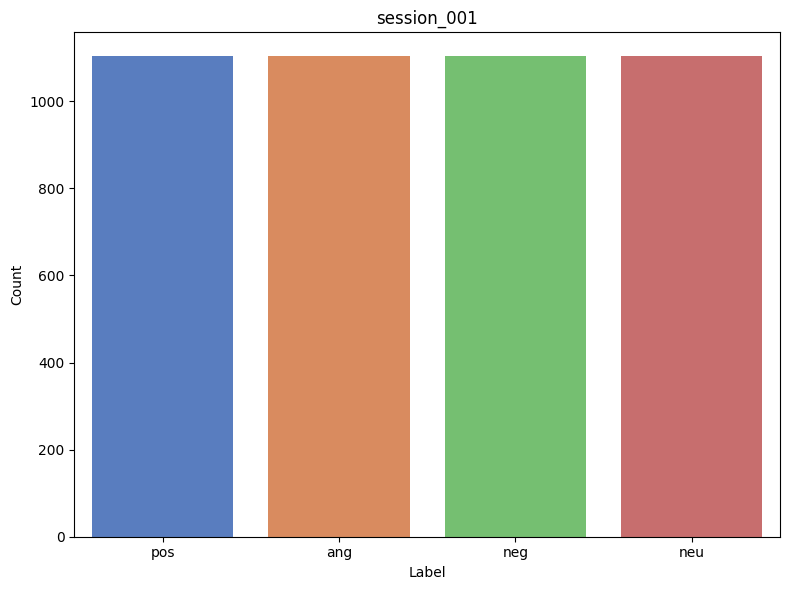

Epoch 1: Loss = 1.3335
Epoch 2: Loss = 1.3191
Epoch 3: Loss = 1.3196
Epoch 4: Loss = 1.3355
Epoch 5: Loss = 1.3112
Epoch 6: Loss = 1.3115
Epoch 7: Loss = 1.3167
Epoch 8: Loss = 1.3086
Epoch 9: Loss = 1.3148
Epoch 10: Loss = 1.3309
Epoch 11: Loss = 1.3136
Epoch 12: Loss = 1.3297
Epoch 13: Loss = 1.3106
Epoch 14: Loss = 1.3258
Epoch 15: Loss = 1.3205
Epoch 16: Loss = 1.3149
Epoch 17: Loss = 1.3247
Epoch 18: Loss = 1.3156
Epoch 19: Loss = 1.3098
Epoch 20: Loss = 1.3070
Epoch 21: Loss = 1.3146
Epoch 22: Loss = 1.3153
Epoch 23: Loss = 1.3006
Epoch 24: Loss = 1.3005
Epoch 25: Loss = 1.3037
Epoch 26: Loss = 1.3124
Epoch 27: Loss = 1.3229
Epoch 28: Loss = 1.3078
Epoch 29: Loss = 1.3066
Epoch 30: Loss = 1.3057
✅ Classification report saved.


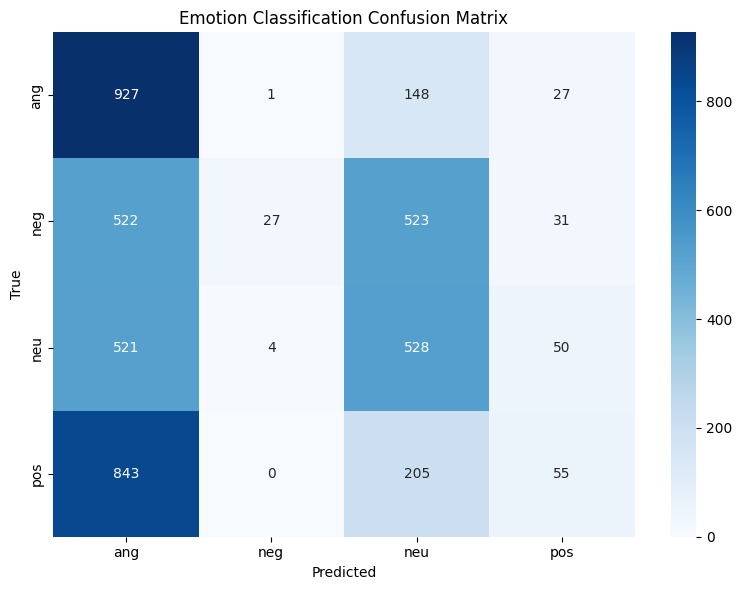

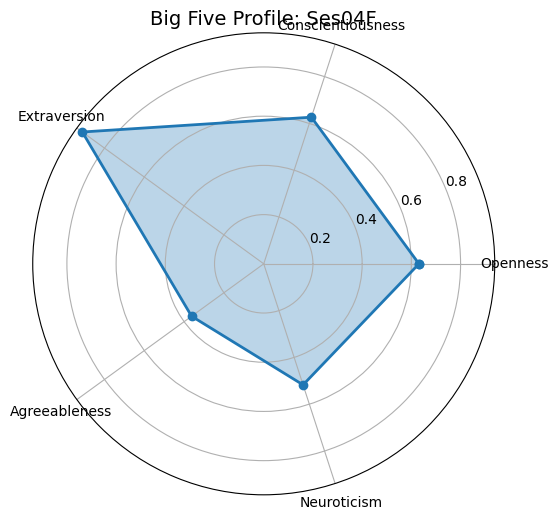

In [14]:
feat_path = "/content/X.npy"
label_path = "/content/y.npy"
speaker_path = "/content/speakers.npy"

session_id = "session_001" # Update manually each time before running this cell

X, y, speakers = load_training_data(feat_path, label_path, speaker_path)
X_bal, y_bal, speakers_bal = remap_and_balance(X, y, speakers)
plot_label_distribution(y_bal, session_id)

dataloader, label_encoder = prepare_dataloader(X_bal, y_bal)
encoder, emo_head = get_models(X.shape[1], len(label_encoder.classes_))

train_emotion_model(encoder, emo_head, dataloader, epochs=30)
evaluate_classifier(X_bal, y_bal, encoder, emo_head, label_encoder)

speaker_emotions, pitch_stats, energy_stats, jitter_stats, rate_stats = run_inference(
    X_bal, speakers_bal, encoder, emo_head, label_encoder)

personality_dict = compute_personality_profiles(
    speaker_emotions, pitch_stats, energy_stats, jitter_stats, rate_stats)

save_session(personality_dict, session_id)

for spk, data in personality_dict.items():
    plot_personality_traits(data["traits"], speaker_id=spk)
    break